# Link prediction using StellarGraph library

* create link model withh RGCN (adapt proposed architecture https://stellargraph.readthedocs.io/en/latest/demos/link-prediction/gcn-link-prediction.html)



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stellargraph as sg
from stellargraph import StellarGraph
from sklearn.model_selection import train_test_split
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator, RelationalFullBatchNodeGenerator, KGTripleGenerator
from stellargraph.layer import RGCN, DistMult, ComplEx, link_classification, LinkEmbedding, GCN
import tensorflow as tf
from tensorflow.keras import Model, optimizers, losses, metrics, utils, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tqdm.keras import TqdmCallback
from stellargraph import datasets, utils

2024-08-20 12:40:52.405865: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 12:40:52.412553: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
my_data = pd.read_csv("PyG_data/cleaned_triples.tsv", header=None, sep='\t' ,names=["subject", "predicate", "object"])
my_data 

,subject,predicate,object
0,Q24011,P127,Q15617809
1,Q24011,P127,Q3591845
2,Q24011,P608,Q15617708
3,Q24011,P921,Q15617727
4,Q24011,P195,Q3044768
...,...,...,...
217173,Q118142339,P195,Q516697
217174,Q118142339,P186,Q296955
217175,Q118142339,P186,Q12321255
217176,Q118142339,P31,Q3305213


In [5]:
graph_edges= my_data[['subject', 'object']]
graph_edges_types = graph_edges.assign(
    orientation=my_data['predicate']
)
graph_edges_types = graph_edges_types.rename(columns={
    'subject': 'source',
    'object': 'target'
})
node_ids = pd.unique(graph_edges_types[['source', 'target']].values.ravel('K'))
node_features = pd.DataFrame(
    np.eye(len(node_ids)),  # Identity matrix for node features
    index=node_ids
)
G = StellarGraph(
    nodes=node_features,
    edges=graph_edges_types, edge_type_column="orientation"
)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 32153, Edges: 217178

 Node types:
  default: [32153]
    Features: float32 vector, length 32153
    Edge types: default-P1028->default, default-P1038->default, default-P106->default, default-P1066->default, default-P1071->default, ... (106 more)

 Edge types:
    default-P180->default: [69953]
        Weights: all 1 (default)
        Features: none
    default-P186->default: [31457]
        Weights: all 1 (default)
        Features: none
    default-P195->default: [19936]
        Weights: all 1 (default)
        Features: none
    default-P31->default: [19812]
        Weights: all 1 (default)
        Features: none
    default-P276->default: [17591]
        Weights: all 1 (default)
        Features: none
    default-P170->default: [14791]
        Weights: all 1 (default)
        Features: none
    default-P136->default: [12323]
        Weights: all 1 (default)
        Features: none
    default-P6216->default: [12088]
        Weights: all 1 

In [6]:
# maps each unique entity from KG  to its graph index
entity2nodeId = {entity: index for index, entity in enumerate(node_ids)}

In [4]:
# #helpers:
# node_id_map = {node_id: idx for idx, node_id in enumerate(node_ids)}

# def edges_to_index(edge_ids, node_id_map):
#     edge_index = np.array([
#         [node_id_map[source], node_id_map[target]] 
#         for source, target in edge_ids
#     ])
#     return tf.convert_to_tensor(edge_index, dtype=tf.int64)

# edge_index = edges_to_index(graph_edges_types[['source', 'target']].values, node_id_map)

# Link prediction using embedding models

In [33]:
Jde_train, temp_df = train_test_split(graph_edges_types, test_size=0.4, random_state=42)
Jde_val, Jde_test = train_test_split(temp_df, test_size=0.5, random_state=42)

Jde_train = Jde_train.rename(columns={'orientation': 'label'})
Jde_val = Jde_val.rename(columns={'orientation': 'label'})
Jde_test = Jde_test.rename(columns={'orientation': 'label'})

Jde_train = Jde_train.reset_index(drop=True)
Jde_val = Jde_val.reset_index(drop=True)
Jde_test = Jde_test.reset_index(drop=True)

In [34]:
epochs = 100
batch_size = len(Jde_train) // 10 # ~10 batches per epoch (13030)
negative_samples= 10

In [35]:
Jde_gen = KGTripleGenerator(
   G, batch_size=batch_size  
)
Jde_ComplEx = ComplEx(
    Jde_gen,
    embedding_dimension=100,
    embeddings_regularizer=regularizers.l2(1e-4),
)

Jde_inp, Jde_out = Jde_ComplEx.in_out_tensors()

Jde_model = Model(inputs=Jde_inp, outputs=Jde_out)

Jde_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=[metrics.BinaryAccuracy(threshold=0.0)],
)

In [36]:
Jde_train_gen = Jde_gen.flow(
   Jde_train,
   negative_samples=negative_samples,# The negative edges are sampled using the "local closed world assumption", where a source/subject or a target/object is randomly mutated
   shuffle=True 
)
Jde_valid_gen = Jde_gen.flow(Jde_val, negative_samples=negative_samples)

In [37]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

In [38]:
Joconde_checkpoint = ModelCheckpoint(
    filepath=f'./sg_EM_results/best_model_ComplEX_{epochs}|{timestamp}.h5',
    monitor='val_loss',        
    save_best_only=True,       
    save_weights_only=False,   #  (architecture + weights)
    mode='min', # minimize the validation loss
    verbose=1                  # 1 = output when a new best model is saved
)

In [39]:
Jde_es = EarlyStopping(monitor="val_loss", patience=10)
Jde_history = Jde_model.fit(
    Jde_train_gen,
    validation_data=Jde_valid_gen,
    epochs=epochs,
    callbacks=[#Jde_es,
            Joconde_checkpoint,
            TqdmCallback(verbose=1)
            ],
    verbose=0,
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 1: val_loss improved from inf to 1.87264, saving model to ./sg_EM_results/best_model_ComplEX_100|20240820-132835.h5

Epoch 2: val_loss improved from 1.87264 to 1.52347, saving model to ./sg_EM_results/best_model_ComplEX_100|20240820-132835.h5

Epoch 3: val_loss improved from 1.52347 to 1.27195, saving model to ./sg_EM_results/best_model_ComplEX_100|20240820-132835.h5

Epoch 4: val_loss improved from 1.27195 to 1.09599, saving model to ./sg_EM_results/best_model_ComplEX_100|20240820-132835.h5

Epoch 5: val_loss improved from 1.09599 to 0.97405, saving model to ./sg_EM_results/best_model_ComplEX_100|20240820-132835.h5

Epoch 6: val_loss improved from 0.97405 to 0.88960, saving model to ./sg_EM_results/best_model_ComplEX_100|20240820-132835.h5

Epoch 7: val_loss improved from 0.88960 to 0.83097, saving model to ./sg_EM_results/best_model_ComplEX_100|20240820-132835.h5

Epoch 8: val_loss improved from 0.83097 to 0.79012, saving model to ./sg_EM_results/best_model_ComplEX_100|2024082

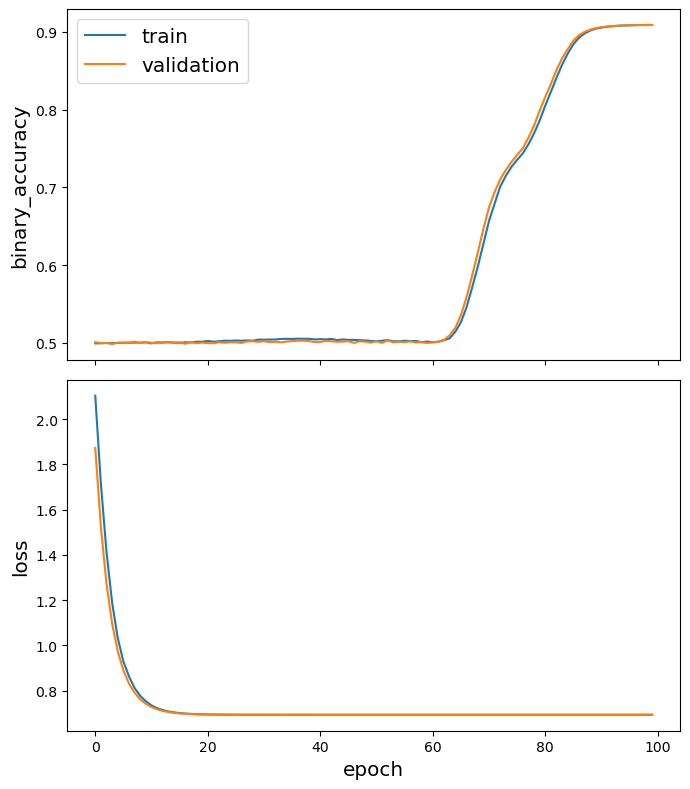

In [40]:
utils.plot_history(Jde_history)

?? generalization
?? write  model checkpoint callback
** no n_feats(Id mat) : Binary acc up to .675 || loss down til .7 , # no disparancies between train and val graph lines

### EVALUATION

In [41]:
help(Jde_ComplEx)

Help on ComplEx in module stellargraph.layer.knowledge_graph object:

class ComplEx(KGModel)
 |  ComplEx(generator, embedding_dimension, embeddings_initializer='normal', embeddings_regularizer=None)
 |  
 |  Embedding layers and a ComplEx scoring layers that implement the ComplEx knowledge graph
 |  embedding algorithm as in http://jmlr.org/proceedings/papers/v48/trouillon16.pdf
 |  
 |  .. seealso::
 |  
 |     Example using ComplEx: `link prediction <https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/complex-link-prediction.html>`__
 |  
 |     Related models: other knowledge graph models, see :class:`.KGTripleGenerator` for a full list.
 |  
 |     Appropriate data generator: :class:`.KGTripleGenerator`.
 |  
 |  Args:
 |      generator (KGTripleGenerator): A generator of triples to feed into the model.
 |  
 |      embedding_dimension (int): the dimension of the embedding (that is, a vector in
 |          ``C^embedding_dimension`` is learnt for each node and each l

In [42]:
# Jde_smaller_gen = KGTripleGenerator(G, batch_size=5000) # swap the batch size by creating a new generator for less memory usage

Jde_raw_ranks, Jde_filtered_ranks = Jde_ComplEx.rank_edges_against_all_nodes(
    Jde_gen.flow(Jde_test),G
)

In [43]:
def results_as_dataframe(name_to_results):
    return pd.DataFrame(
        name_to_results.values(),
        columns=["MRR", "hits@1", "hits@3", "hits@10"],
        index=name_to_results.keys(),
    )


def summarise(name_to_ranks):
    return results_as_dataframe(
        {
            name: (
                np.mean(1 / ranks),
                np.mean(ranks <= 1),
                np.mean(ranks < 3),
                np.mean(ranks <= 10),
            )
            for name, ranks in name_to_ranks.items()
        }
    )

In [44]:
summarise({"raw": Jde_raw_ranks, "filtered": Jde_filtered_ranks})

,MRR,hits@1,hits@3,hits@10
raw,0.000388,0.000023,0.000069,0.000322
filtered,0.000382,0.000023,0.000046,0.000276


Edge Splitting by Edge Type: 

In [45]:
edge_type_counts = graph_edges_types.groupby('orientation').size().reset_index(name='edge_count')

edge_type_counts = edge_type_counts.sort_values(by='edge_count', ascending=False)
edge_type_counts

,orientation,edge_count
34,P180,69953
36,P186,31457
41,P195,19936
60,P31,19812
57,P276,17591
...,...,...
78,P547,1
11,P1303,1
10,P1299,1
85,P6275,1


In [ ]:
# plt.figure(figsize=(4, 15))
# sns.barplot(x='edge_count', y='orientation', data=edge_type_counts, palette="viridis")

# plt.xscale('log')

# plt.title('Number of Edges per Edge Type (Logarithmic Scale)', fontsize=16)
# plt.xlabel('Number of Edges (Log Scale)', fontsize=14)
# plt.ylabel('Edge Type', fontsize=14)

# plt.show()

In [ ]:
# train_graph_edges = {}
# test_graph_edges = {}

# for edge_type in G.edge_types:

#     edges_of_type = G.edges(include_edge_type=edge_type, include_edge_weight=False)
    
#     edges_of_type_df = pd.DataFrame([(edge[0], edge[1]) for edge in edges_of_type], columns=["source", "target"])
#     nodes_in_edges = pd.unique(edges_of_type_df[['source', 'target']].values.ravel('K'))

#     node_features_of_type = node_features.loc[nodes_in_edges]
#     subgraph = StellarGraph(nodes=node_features_of_type, edges=edges_of_type_df)
    
  
#     edge_splitter = EdgeSplitter(subgraph)
#     subgraph_train, edge_labels, edge_ids = edge_splitter.train_test_split(
#         p=0.1,  # 10% as test set
#         method="global",  
#         keep_connected=True  
#     )
    
#     test_edges = edges_of_type_df.loc[edges_of_type_df.index.isin(edge_ids)]

#     train_edges = edges_of_type_df.loc[~edges_of_type_df.index.isin(edge_ids)]
    
#     train_graph_edges[edge_type] = train_edges
#     test_graph_edges[edge_type] = test_edges

# G_train = StellarGraph(nodes=G.nodes(), edges=train_graph_edges)
# G_test = StellarGraph(nodes=G.nodes(), edges=test_graph_edges)

In [6]:
edge_splitter_test = EdgeSplitter(G)
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True #control change NS methods 
)
edge_splitter_train = EdgeSplitter(G_test)
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 21717 positive and 21717 negative edges. **
** Sampled 19546 positive and 19546 negative edges. **


# Link prediction using GCN

In [7]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [8]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [9]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [10]:
x_inp, x_out = gcn.in_out_tensors()

In [11]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [12]:
prediction = tf.keras.layers.Reshape((-1,))(prediction)

In [13]:
model = tf.keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.binary_crossentropy,
    # not just "acc" due to https://github.com/tensorflow/tensorflow/issues/41361
    metrics=["binary_accuracy"],
)

In [14]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 7s 7s/step - loss: 5.8966 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 5.8549
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 5.8966
	binary_accuracy: 0.5000


In [15]:
history = model.fit(
    train_flow, epochs=50, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 18s - loss: 5.7105 - binary_accuracy: 0.5000 - val_loss: 2.0360 - val_binary_accuracy: 0.5000 - 18s/epoch - 18s/step
Epoch 2/50
1/1 - 11s - loss: 2.0405 - binary_accuracy: 0.5000 - val_loss: 1.3761 - val_binary_accuracy: 0.5002 - 11s/epoch - 11s/step
Epoch 3/50
1/1 - 11s - loss: 1.3842 - binary_accuracy: 0.5002 - val_loss: 0.9865 - val_binary_accuracy: 0.5842 - 11s/epoch - 11s/step
Epoch 4/50
1/1 - 10s - loss: 0.9946 - binary_accuracy: 0.5785 - val_loss: 0.7152 - val_binary_accuracy: 0.6689 - 10s/epoch - 10s/step
Epoch 5/50
1/1 - 11s - loss: 0.7198 - binary_accuracy: 0.6681 - val_loss: 0.5547 - val_binary_accuracy: 0.7268 - 11s/epoch - 11s/step
Epoch 6/50
1/1 - 9s - loss: 0.5626 - binary_accuracy: 0.7231 - val_loss: 0.4510 - val_binary_accuracy: 0.7648 - 9s/epoch - 9s/step
Epoch 7/50
1/1 - 11s - loss: 0.4569 - binary_accuracy: 0.7626 - val_loss: 0.3861 - val_binary_accuracy: 0.8020 - 11s/epoch - 11s/step
Epoch 8/50
1/1 - 10s - loss: 0.3980 - binary_accuracy: 0.7973 - v

In [16]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 4s 4s/step - loss: 0.3234 - binary_accuracy: 0.8715

Train Set Metrics of the trained model:
	loss: 0.3152
	binary_accuracy: 0.8721

Test Set Metrics of the trained model:
	loss: 0.3234
	binary_accuracy: 0.8715


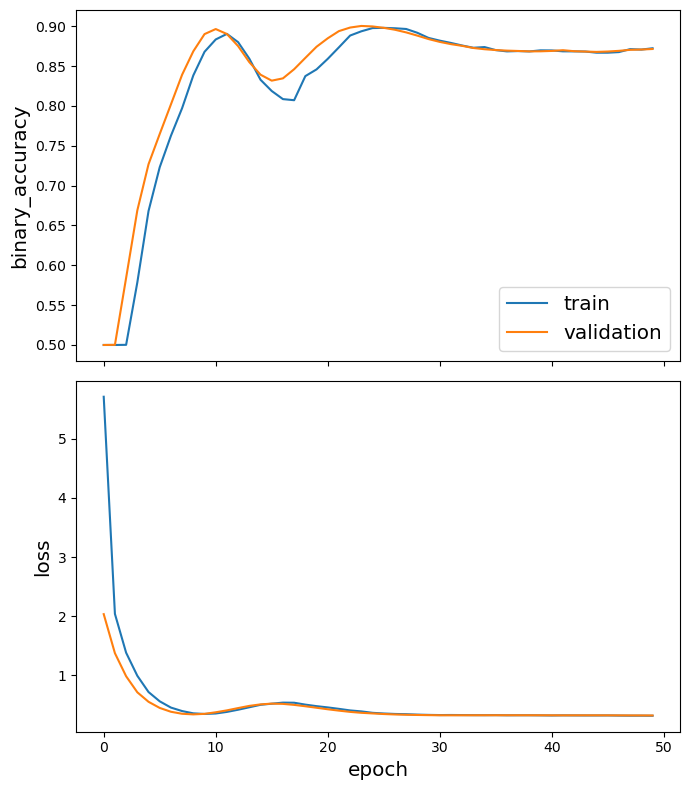

In [17]:
sg.utils.plot_history(history)


In [21]:
# model.save('trained_gcn_on_cleaned_reduced_Jde.h5')

In [25]:
embedding_model = tf.keras.Model(inputs=x_inp, outputs=x_out)
node_embeddings = embedding_model.predict(train_flow)


In [40]:
node_embeddings.shape
node_embeddings.reshape((39092, 16))

(1, 39092, 2, 16)

In [56]:
h =entity2nodeId['Q24011']



In [55]:
h_embedding = node_embeddings[0, h, 0, :] #(16,)
all_embeddings = node_embeddings[0, :, 0, :]  # (39092, 16)
scores = np.dot(h_embedding, all_embeddings.T)  #(39092,)

sorted_indices = np.argsort(scores)[::-1]
results = []

for i, t in enumerate(sorted_indices):
    rank = i + 1  # 1-based
    

    mean_rank = rank
    mrr = 1.0 / rank
    hits_at_10 = 1.0 if rank <= 10 else 0

    results.append({
        'Tail_Node_ID': t,
        'Rank': rank,
        'Mean_Rank': mean_rank,
        'MRR': mrr,
        'Hits@10': hits_at_10
    })


results_df = pd.DataFrame(results)
results_df


,Tail_Node_ID,Rank,Mean_Rank,MRR,Hits@10
0,31670,1,1,1.000000,1.0
1,36233,2,2,0.500000,1.0
2,37927,3,3,0.333333,1.0
3,29302,4,4,0.250000,1.0
4,31792,5,5,0.200000,1.0
...,...,...,...,...,...
39087,21496,39088,39088,0.000026,0.0
39088,34893,39089,39089,0.000026,0.0
39089,38985,39090,39090,0.000026,0.0
39090,35414,39091,39091,0.000026,0.0


### Relational GNNS

In [7]:
generator = RelationalFullBatchNodeGenerator(G_train)  #Relational Full Batch 'Link' Generator??
all_node_ids = list(G_train.nodes())
train_gen = generator.flow(node_ids=all_node_ids)

In [ ]:
rgcn = RGCN(
    layer_sizes=[32, 32],  # Two RGCN layers, each with 32 units
    activations=["relu", "relu"],
    generator=generator,
    bias=True,
    dropout=0.5,
)

x_inp, x_out = rgcn.in_out_tensors()
model = Model(inputs=x_inp, outputs=x_out)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.categorical_crossentropy,
)
print(model.summary())

!! RelationalFullBatchNodeGenerator require node features 
* Without Node Features (Identity Matrix) 
* With Random Node Features #introduce some variability 
* Using Structural Features (Node Degrees) #information about connectivity

???!!StellarGraph library's RGCN model is primarily designed for semi-supervised tasks, meaning it expects node labels for training.
* RGCN with Self-Supervision
* Node2Vec  approach 